In [2]:
import pandas as pd
import xgboost as xgb
from helpers import get_average_player_performances, get_score_df
from simulation import simulate_nba_matchup, simulate_regular_season, simulate_arbitrary_matchup, run_tournament, test_team, get_super_team, nba_trade_finder, build_team_around_player, get_super_team_for_player

**Superteam**

This project aimed to identify sets of players that collectively form strong basketball teams using machine learning and advanced statistics. Such a tool would allow general managers to make more informed decisions in building their rosters. By collecting a wide variety of individual player and collective team performance data from over 10000 NBA games dating back to 2015, the goal was to identify a mapping from teams' combined player performance data to the outcome of the corresponding game. This mapping then allows for building custom teams by aggregating individual player performances.

**Assumptions**

A team's performance can only be judged relative to another group, and it is crucial to include both competing teams' player performances when predicting the outcome of a game. Moreover, instead of simply mapping to a binary win-loss condition, I used the team's plus-minus score. This score is purely relative and allows the model to pick up on more detailed correlations suggesting why a set of players may have been better than another set of players.

Initially, I assumed that mapping from collective player performances to team performance and then mapping from team performance to the plus-minus results would yield the best results. However, it turned out that while second mapping had a very high accuracy, the formed did not. Moreover, the mapping from individual player performance to team performance in large parts is trivial. For example, the number of team assists would simply be the sum of all player's assists. Instead of using two models, I decided to simply use a single model which maps directly from a set of individual player performances for both teams to a plus-minus score.

A given player's performance data is simply averaged over a given period, such as the current season, and is then grouped with the average performances of other players.

**Data**

As mentioned, the input data our model was trained on was a set of individual player performance statistics. The output data of our model was the associated games plus-minus result. To collect all this data, we used the python nba_api (https://github.com/swar/nba_api), which allows programmatic access to all statistics stored on NBA.com. For every game, we then collect more than 100 statistics (see models.py) for every player who played that game and the entire team's statistics and store them in a separate database. 

By stacking this player performance data into a single row of data for each game and then mapping it to the plus-minus score of the corresponding team, we build up our training dataset. For the whole team model with 13 players per team, we then have 26*105=2730 features for each game where the first 1365 features correspond to the first team's player features and the latter half corresponds to the other team's features. The plus-minus score is then always given with respect to the first team. This way, we can double the size of our dataset by using each game twice and switching the order of the two groups and the sign of the plus-minus score, as this is symmetric under a switch of teams.

**Model**

We then train a regression model using the extreme gradient boosting library xgboost (https://github.com/dmlc/xgboost) and achieve remarkable accuracy of 98% in predicting which of the two teams won. Moreover, the root means square error in predicting the plus-minus score by which a team won or lost is approximately equal to 2, indicating that we can predict the number of points by which a team wins or loses with an error of roughly 2 points. As we decrease the number of players on each team, our model's rmse increases.

For our model to work, we require a fixed number of players on each team, and we provide various team-sized models ranging from one player to 13 players.


In [17]:
model_13 = xgb.XGBRegressor()
model_13.load_model('models/13_player_model_small.json')
model_10 = xgb.XGBRegressor()
model_10.load_model('models/10_player_model.json')
model_5 = xgb.XGBRegressor()
model_5.load_model('models/5_player_model.json')
model_1 = xgb.XGBRegressor()
model_1.load_model('models/1_player_model.json')

In [4]:
print(f'RMSE (13 players): {model_13.best_score}')
print(f'RMSE (10 players): {model_10.best_score}')
print(f'RMSE (5 plyaers): {model_5.best_score}')
print(f'RMSE (1 player): {model_1.best_score}')

RMSE (13 players): 2.173604
RMSE (10 players): 3.06293
RMSE (5 plyaers): 4.549689
RMSE (1 player): 6.275678


Now that we have trained our models, which can predict the outcome of a matchup between two sets of player performances, we calculate the average performance data for each active player throughout a season and use this as our input data. Now let's build some cool apps using our model.

**Apps**

First up, let's get all individual player performance data for the 2021-22 NBA season and calculate the average values for each player. As you can see from the dataset below, we have 542 different players with 105 average features each as our input data.

In [4]:
data = pd.read_csv('data/22021_data.csv').set_index('_id').drop('GAME_ID',axis=1)
average_data = get_average_player_performances(data)
average_data

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,PCT_FGA_2PT,PCT_AST_2PM,PCT_PTS_2PT,AST_PCT,PCT_FG3M,PCT_BLKA,PCT_BLK,...,E_PACE,AST_RATIO,DIST,AST_TOV,FTA_RATE,OPP_FTA_RATE,MIN,PACE_PER40,PACE,PIE
0,2544,LeBron James,LAL,0.616889,0.396083,0.558722,0.274778,0.275194,0.227389,0.226778,...,100.016944,18.041667,2.320556,2.092778,0.235278,0.242222,35.941111,82.418889,98.901944,0.170389
1,2546,Carmelo Anthony,LAL,0.435622,0.405267,0.382422,0.062222,0.305289,0.122200,0.262600,...,102.498444,8.057778,1.736000,0.722222,0.285244,0.276111,25.529111,85.285556,102.343333,0.094756
2,2617,Udonis Haslem,MIA,0.149340,0.090000,0.131420,0.015160,0.010000,0.040000,0.000000,...,17.209600,1.008000,0.089600,0.040000,0.017300,0.078300,1.283800,15.179200,18.214600,0.017500
3,2730,Dwight Howard,LAL,0.729958,0.512563,0.465021,0.040104,0.046521,0.162500,0.295125,...,81.013542,5.902083,0.957500,0.201250,0.205646,0.222375,13.528750,66.718125,80.061250,0.086667
4,2738,Andre Iguodala,GSW,0.374920,0.326680,0.323320,0.222040,0.127960,0.025720,0.269960,...,89.253200,37.884000,1.170000,1.726400,0.187880,0.209920,17.071200,73.984000,88.778800,0.097840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,1630691,Jamorko Pickett,DET,0.081600,0.100000,0.082500,0.013900,0.133300,0.025000,0.033350,...,44.572500,2.500000,0.343500,0.000000,0.163300,0.156000,4.388500,38.274500,45.929500,0.040750
631,1630692,Jordan Goodwin,WAS,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,21.850000,0.000000,0.060000,0.000000,0.000000,0.041750,0.630000,15.697500,18.837500,-0.043500
632,1630693,Jaime Echenique,WAS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
633,1630695,Micah Potter,DET,0.250000,0.166750,0.187500,0.000000,0.000000,0.000000,0.000000,...,59.565000,0.000000,0.372500,0.000000,0.114250,0.062500,4.377500,46.822500,56.187500,0.054250


**Matchup**

Now we can use this data to simulate a game between two teams. Let's match up the Boston Celtics (BOS) and the Pheonix Suns (PHX) using a team size of 13 players per team.

In [6]:
(bos_pm, phx_pm) = simulate_nba_matchup('BOS','PHX',average_data,model=model_13,team_size=13)
print(f'Plus Minus (BOS): {bos_pm}')
print(f'Plus Minus (PHX): {phx_pm}')

Plus Minus (BOS): 4.734989166259766
Plus Minus (PHX): -0.42579782009124756


Our model predicts that the Celtics will win by 4.73 points over the Suns when playing in Boston and that the Suns will lose by -0.43 points when playing in Pheonix. The winner of this matchup will therefore be the Boston Celtics.

We can also match up imaginary teams and see who wins. As an example, we can randomly sample two sets of 13 players.

In [7]:
team_a = average_data.sample(13)
team_a_players = team_a.PLAYER_NAME.to_list()
team_a_ids = team_a.PLAYER_ID.to_list()
team_b = average_data[~average_data['PLAYER_ID'].isin(team_a_ids)].sample(13)
team_b_players = team_b.PLAYER_NAME.to_list()
team_b_ids = team_b.PLAYER_ID.to_list()
(team_a_pm, team_b_pm) = simulate_arbitrary_matchup(team_a_ids, team_b_ids, average_data,model=model_13,team_size=13)
print(f'Players (A): {team_a_players}')
print(f'Players (B): {team_b_players}')
print(f'Plus Minus (A): {team_a_pm}')
print(f'Plus Minus (B): {team_b_pm}')

Players (A): ['Caris LeVert', 'Langston Galloway', 'Tristan Thompson', 'Jordan Clarkson', 'Bruno Fernando', 'Taj Gibson', 'Dennis Schroder', 'Bam Adebayo', 'Wenyen Gabriel', 'Sam Merrill', 'Max Strus', 'Richaun Holmes', 'Jalen Smith']
Players (B): ['OG Anunoby', 'Moses Brown', 'Mike Muscala', 'Rajon Rondo', 'Kevin Porter Jr.', 'Deni Avdija', 'DeMar DeRozan', 'Moritz Wagner', 'Jake Layman', 'Andre Drummond', 'R.J. Hampton', 'Jusuf Nurkic', 'Chaundee Brown Jr.']
Plus Minus (A): -1.53811514377594
Plus Minus (B): 1.096522569656372


**Regular Season Standings**

Now that we can simulate any matchup let's simulate all possible matchups in the NBA and find out who the best current teams are.

In [14]:
regular_season_results = simulate_regular_season(average_data,model=model_13,team_size=13)
print(regular_season_results)

100%|██████████| 30/30 [00:17<00:00,  1.70it/s]

{'BOS': 1.0, 'UTA': 0.9655172413793104, 'PHX': 0.9310344827586207, 'GSW': 0.8620689655172413, 'CLE': 0.8620689655172413, 'MEM': 0.8275862068965517, 'MIA': 0.7586206896551724, 'BKN': 0.7586206896551724, 'ATL': 0.7241379310344828, 'MIL': 0.7241379310344828, 'SAS': 0.6896551724137931, 'MIN': 0.6206896551724138, 'DAL': 0.5862068965517241, 'PHI': 0.5517241379310345, 'DEN': 0.5172413793103449, 'CHA': 0.4827586206896552, 'TOR': 0.4482758620689655, 'CHI': 0.41379310344827586, 'NOP': 0.3448275862068966, 'LAC': 0.3103448275862069, 'POR': 0.3103448275862069, 'WAS': 0.3103448275862069, 'NYK': 0.27586206896551724, 'IND': 0.20689655172413793, 'HOU': 0.1724137931034483, 'SAC': 0.13793103448275862, 'OKC': 0.10344827586206896, 'LAL': 0.06896551724137931, 'ORL': 0.034482758620689655, 'DET': 0.0}


These win-loss results show that Boston is the best team in the NBA, winning against all other teams, while Utah and Pheonix are their strongest competition this year. On the other end, Detroit, Orlando, and the L.A. Lakers have the lowest win-to-loss ratios, with Detriot unable to win against any team. By comparing this with the actual standings of the current NBA season, we see a clear correlation indicating the model's predictive power.

**Tournament**



One of our primary goals is to identify strong teams by combining different players. Therefore I designed an elimination tournament system similar to the playoffs. Initially, teams are randomly sampled from the player pool, and the team that wins the tournament then goes on to another tournament where new teams are sampled. Eventually, a team will emerge which remains unbeaten.

In [35]:
winner_list = run_tournament(average_data, model=model_13,rounds=3,team_count=32,team_size=13)

 33%|███▎      | 1/3 [00:00<00:01,  1.30it/s]

Winner Team:  ['Kevin Durant', 'Mikal Bridges', 'Tyrese Maxey', "D'Angelo Russell", 'Spencer Dinwiddie', 'Steven Adams', 'Jalen Smith', 'Frank Kaminsky', 'Keifer Sykes', 'Reggie Perry', 'Enes Freedom', 'Kent Bazemore', 'Chris Chiozza']


 67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

Winner Team:  ['Kevin Durant', 'Mikal Bridges', 'Tyrese Maxey', "D'Angelo Russell", 'Spencer Dinwiddie', 'Steven Adams', 'Jalen Smith', 'Frank Kaminsky', 'Keifer Sykes', 'Reggie Perry', 'Enes Freedom', 'Kent Bazemore', 'Chris Chiozza']


100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

Winner Team:  ['Kevin Durant', 'Mikal Bridges', 'Tyrese Maxey', "D'Angelo Russell", 'Spencer Dinwiddie', 'Steven Adams', 'Jalen Smith', 'Frank Kaminsky', 'Keifer Sykes', 'Reggie Perry', 'Enes Freedom', 'Kent Bazemore', 'Chris Chiozza']


By running the tournament using our single player model we can identify which player has the most influnece on their team winning a game which is what the MVP Award is ultimately all about.

In [24]:
mvp_candidates = run_tournament(average_data, model=model_1,rounds=2,team_count=512,team_size=1)

 50%|█████     | 1/2 [00:07<00:07,  7.76s/it]

Winner Team:  ['Jayson Tatum']


100%|██████████| 2/2 [00:16<00:00,  8.24s/it]

Winner Team:  ['Jayson Tatum']


According to this analysis, Jayson Tatum is the real MVP this year.

Next, we can test any individual team by matching it up against many randomly sampled teams and recording the win-loss statistics. Let us take the last team to win the tournament above.

In [36]:
win_loss_mean = test_team(winner_list[-1],average_data,model=model_13,team_size=13)
print(f'Win/Loss Ratio: {win_loss_mean}')

100%|██████████| 100/100 [00:03<00:00, 29.83it/s]

Win/Loss Ratio: 0.99


**Superteam Finder**

Another way to identify a strong team would be to find a team that beats another team and then continue until a given team cannot be beaten by any arbitrary team.

In [8]:
super_team_ids = get_super_team(average_data, model=model_13,team_size=13,iterations=10, test_teams=100)
print(average_data[average_data.PLAYER_ID.isin(super_team_ids)].PLAYER_NAME.drop_duplicates().to_list())

100%|██████████| 100/100 [00:01<00:00, 78.91it/s]


W/L:  0.95


100%|██████████| 100/100 [00:01<00:00, 77.12it/s]


W/L:  0.89


100%|██████████| 100/100 [00:01<00:00, 76.89it/s]


W/L:  0.99


100%|██████████| 100/100 [00:01<00:00, 70.97it/s]


W/L:  0.96


100%|██████████| 100/100 [00:01<00:00, 74.10it/s]

W/L:  1.0
Super Team Found
['Al-Farouq Aminu', 'Reggie Bullock', 'Jordan Clarkson', 'Domantas Sabonis', 'Derrick White', 'Keita Bates-Diop', 'Jalen Brunson', 'Terence Davis', 'Ty Jerome', 'Neemias Queta', 'Didi Louzada', 'Onyeka Okongwu', 'Duane Washington Jr.']


Next, we will build a trade finder that compares a team's performance to its performance if it makes a player trade. By iteratively doing this and keeping track of the win-loss statistics for each potential trade, the best trade is found by maximizing the win-loss ratio. However, to build a realistic trade finder, we first need to calculate an approximate trade value for each player, as some players are worth more than others, and trades need to remain fair for both parties.

**Trade Value Calculation**

We propose a straightforward calculation to rank all players in our player pool. Simply normalize all of our average data features overall players and then sum them for each player. Doing so, we get the following ranking.

In [5]:
trade_value_df = get_score_df(average_data)
trade_value_df.head(10)

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,SCORE
0,203999,Nikola Jokic,DEN,1.000000
1,1629029,Luka Doncic,DAL,0.960294
2,203507,Giannis Antetokounmpo,MIL,0.959715
3,203954,Joel Embiid,PHI,0.949833
4,2544,LeBron James,LAL,0.912045
5,201142,Kevin Durant,BKN,0.906500
6,1629027,Trae Young,ATL,0.901349
7,1626157,Karl-Anthony Towns,MIN,0.883402
8,1629630,Ja Morant,MEM,0.878764
9,201935,James Harden,PHI,0.878221


Interestingly, 3 out of the top 5 players (Jokic, Giannis, and Embiid) in our ranking are considered contenders for this season's MVP Award. By plotting the distribution of scores of all players, we see an interesting trend illustrating how difficult it is to be at the very top of our ranking.

<AxesSubplot:>

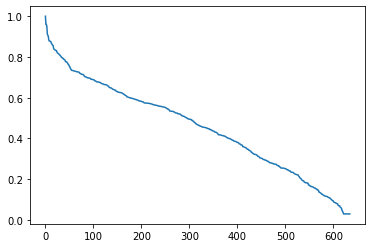

In [9]:
trade_value_df.SCORE.plot()

**Trade Finder**

We can use this ranking to build our trade finder by only allowing trades between players with similar rankings. Let's look at possible beneficial trades for the Charlotte Hornets by matching them against other NBA teams.

In [8]:
nba_trade_finder('CHA', trade_value_df,average_data,model=model_13,team_size=13,samples=10)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Trade LaMelo Ball for Jaylen Brown to improve from 0.5 to 0.6 W/L


From the above trade, we can learn that while Jaylen Brown may be better than LaMelo Ball, LaMelo possibly has a much higher potential as he's still a very young player. This is something our trade finder can't measure as of now. One possible way of measuring potential would be to predict future player performance by looking at trends in past player performance.

We can also do the same by matching up the team against a set of randomly selected teams instead of actual NBA teams.

**Building a Team around a given Player**

Another possible application of our model would be to build a team around a given player. For example, lets build a team around Giannis Antetokounmpo by finding the team with highest win loss ratio. As of now have have imposed no restrictions on the total trade value of the team (similar to a salary cap)

In [5]:
(team, score)=build_team_around_player('Giannis Antetokounmpo',average_data, model=model_13,team_size=13,iterations=10,test_teams=50)

100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


In [8]:
print('Team: ',team)
print(f'W/L Ratio: {score}')

Team:  ['Giannis Antetokounmpo', 'Collin Sexton', 'Caris LeVert', 'Devin Booker', 'Derrick White', 'Steven Adams', 'Jarred Vanderbilt', 'Deandre Ayton', 'Malcolm Brogdon', 'Isaiah Hartenstein', 'Dewayne Dedmon', 'Neemias Queta', 'Udonis Haslem']
W/L Ratio: 1.0


Another possible application of our model would be to build a team around a given player. For example, let's create a team around Giannis Antetokounmpo by finding the team with the highest win-loss ratio. As of now have imposed no restrictions on the total trade value of the group of players (similar to a salary cap)

In [10]:
super_team_ids = get_super_team_for_player(average_data,'Giannis Antetokounmpo',model=model_13,team_size=13)
print(average_data[average_data.PLAYER_ID.isin(super_team_ids)].sort_values('MIN', ascending=False).PLAYER_NAME.drop_duplicates().to_list())

100%|██████████| 100/100 [00:02<00:00, 49.76it/s]


W/L:  0.8


100%|██████████| 100/100 [00:01<00:00, 50.92it/s]


W/L:  0.97


100%|██████████| 100/100 [00:01<00:00, 51.01it/s]

W/L:  1.0
Super Team Found
['Trae Young', 'Joel Embiid', 'Giannis Antetokounmpo', 'Rudy Gobert', 'Devin Booker', 'Wes Iwundu', 'Cameron Johnson', 'Cameron Payne', 'Hassan Whiteside', 'Vlatko Cancar', 'Moses Brown', 'Miles McBride', 'Tacko Fall']


**Further Extensions**

These are just some of the potential applications built using the models presented. Feel free to create more. For instance, we could add salary caps to all teams using the trade value data we calculated to build realistic teams.

It would also be essential to understand why some teams are better than others. All that can be used as clues are the feature importance of the individual model.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='weight', ylabel='Features'>

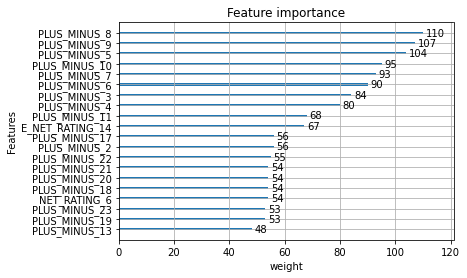

In [28]:
xgb.plot_importance(model_13,max_num_features=20,importance_type='weight',xlabel='weight')

As we can see, a player's plus-minus score and net rating are considered most important in predicting the overall team plus-minus score (here, the number suffix of the feature name indicates the player's importance in the team measure in terms of minutes played going from 1 to 13 for the home team and 14-26 for the away team).

If we sort our average season data by plus-minus scores, we see why our model may think the Boston Celtics will win this year's Playoffs and why Jayson Tatum is this year's MVP.


In [34]:
average_data.sort_values('PLUS_MINUS',ascending=False).head(10)

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,PCT_FGA_2PT,PCT_AST_2PM,PCT_PTS_2PT,AST_PCT,PCT_FG3M,PCT_BLKA,PCT_BLK,...,E_PACE,AST_RATIO,DIST,AST_TOV,FTA_RATE,OPP_FTA_RATE,MIN,PACE_PER40,PACE,PIE
257,1628369,Jayson Tatum,BOS,0.580366,0.383707,0.493049,0.216439,0.281488,0.327439,0.139463,...,98.590244,15.714634,2.442195,2.040244,0.244610,0.232585,35.524878,81.587317,97.904634,0.166293
222,1627759,Jaylen Brown,BOS,0.607811,0.416973,0.535324,0.193757,0.286486,0.453486,0.080189,...,99.776486,13.021622,2.354595,1.376757,0.234000,0.246622,32.475405,82.661622,99.194595,0.154486
153,203935,Marcus Smart,BOS,0.511132,0.292947,0.471079,0.236395,0.193000,0.111421,0.103605,...,100.551053,31.021053,2.177895,2.529474,0.244184,0.241816,31.342632,83.090789,99.708947,0.095921
357,1629057,Robert Williams III,BOS,0.965676,0.635559,0.821147,0.081588,0.000000,0.029412,0.500265,...,95.661765,18.741176,1.932941,0.627353,0.213029,0.214206,27.555588,79.205882,95.046765,0.138000
44,201939,Stephen Curry,GSW,0.370705,0.401136,0.297659,0.272159,0.411523,0.165636,0.106977,...,102.290455,19.927273,2.581591,2.330682,0.223250,0.243523,34.775455,84.280682,101.137045,0.148205
17,201143,Al Horford,BOS,0.512385,0.618846,0.475641,0.156026,0.169410,0.114769,0.363538,...,98.465385,24.528205,2.054359,1.418974,0.214333,0.222154,28.863590,81.663846,97.997179,0.125718
276,1628401,Derrick White,BOS,0.528375,0.411438,0.440937,0.195250,0.146437,0.194750,0.124250,...,97.995625,24.125000,1.996250,1.552500,0.278562,0.282750,27.426875,81.803125,98.165625,0.078250
133,203507,Giannis Antetokounmpo,MIL,0.778200,0.433380,0.599120,0.302380,0.112880,0.315140,0.419660,...,101.595800,17.848000,2.286000,2.173200,0.301680,0.205740,32.142600,84.209600,101.052000,0.209260
306,1628969,Mikal Bridges,PHX,0.627407,0.730458,0.573186,0.088254,0.176898,0.125424,0.117203,...,101.646102,15.716949,2.621525,1.030847,0.214814,0.246492,34.809322,83.991186,100.789322,0.090339
35,201588,George Hill,MIL,0.479805,0.349585,0.408976,0.121122,0.095561,0.097780,0.012195,...,99.780732,26.126829,1.666829,1.115854,0.252976,0.229220,22.114878,83.159024,99.791707,0.063439


**Limitations**

Our model relies heavily on the individual plus-minus scores of individual players. It may be a limitation of our model as it would favor players currently playing on winning teams while unfairly penalizing players playing on losing teams. Nevertheless, keeping the individual plus-minus scores of players as features makes sense as they provide valuable information about a player's performance.

**Conclusion**

We have to build a set of models helpful in predicting who wins a basketball game based on the individual player statistics of players on both teams. The models can then be used in various applications, for example, a trade finder that can suggest trades for a specific NBA team. Our analysis predicts that the Boston Celtics will win this year's playoffs.